In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("amz_uk_price_prediction_dataset.csv")

In [3]:
df

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers
...,...,...,...,...,...,...,...,...,...
2443646,2828589,B0CHSD7P2Q,"Motorbike Armour, Motorbike Clothing, Cycling ...",0.0,0,22.34,False,0,Motorbike Clothing
2443647,2828590,B0B7B8FNBQ,PROFIRST Waterproof Motorcycle 2 Piece Ladies ...,0.0,0,97.99,False,0,Motorbike Clothing
2443648,2828591,B0BD5FL5FB,Men’s Motorcycle Motorbike Biker Trousers Kevl...,0.0,0,52.99,False,0,Motorbike Clothing
2443649,2828592,B008OYLL4I,Texpeed Mens Motorcycle Motorbike Biker Trouse...,4.3,404,79.99,False,0,Motorbike Clothing


In [4]:
df.columns.tolist()

['uid',
 'asin',
 'title',
 'stars',
 'reviews',
 'price',
 'isBestSeller',
 'boughtInLastMonth',
 'category']

In [5]:
df.head()

,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,1,B09B96TG33,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
1,2,B01HTH3C8S,"Anker Soundcore mini, Super-Portable Bluetooth...",4.7,98099,23.99,True,0,Hi-Fi Speakers
2,3,B09B8YWXDF,"Echo Dot (5th generation, 2022 release) | Big ...",4.7,15308,21.99,False,0,Hi-Fi Speakers
3,4,B09B8T5VGV,"Echo Dot with clock (5th generation, 2022 rele...",4.7,7205,31.99,False,0,Hi-Fi Speakers
4,5,B09WX6QD65,Introducing Echo Pop | Full sound compact Wi-F...,4.6,1881,17.99,False,0,Hi-Fi Speakers


#### Part 1: Analyzing Best-Seller Trends Across Product Categories

#### Crosstab Analysis:

In [6]:
# Crosstab between 'category' and 'isBestSeller'
crosstab_bestseller = pd.crosstab(index=df['category'], columns=df['isBestSeller'])

# Display frequency table
crosstab_bestseller.head()

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3


In [7]:
# Calculate proportion of best-sellers for each category
bestseller_proportion = (df.groupby('category')['isBestSeller']
                            .mean()
                            .sort_values(ascending=False))

# Display the top categories
bestseller_proportion.head(10)


category
Grocery                           0.058135
Smart Home Security & Lighting    0.057692
Health & Personal Care            0.057686
Mobile Phone Accessories          0.042471
Power & Hand Tools                0.035339
Billiard, Snooker & Pool          0.032129
Pet Supplies                      0.030200
Home Brewing & Wine Making        0.028455
Mirrors                           0.028000
Wind Instruments                  0.028000
Name: isBestSeller, dtype: float64

#### Statistical Tests

Chi Square

In [8]:
from scipy.stats import chi2_contingency

# Crosstab between product category and best-seller status
crosstab_result = pd.crosstab(df['category'], df['isBestSeller'])

# Chi-square test
_, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

chi2_p_value

np.float64(0.0)

Cramer

In [9]:
from scipy.stats.contingency import association
association(crosstab_result, method="cramer")

0.1222829439760564

#### Visualization

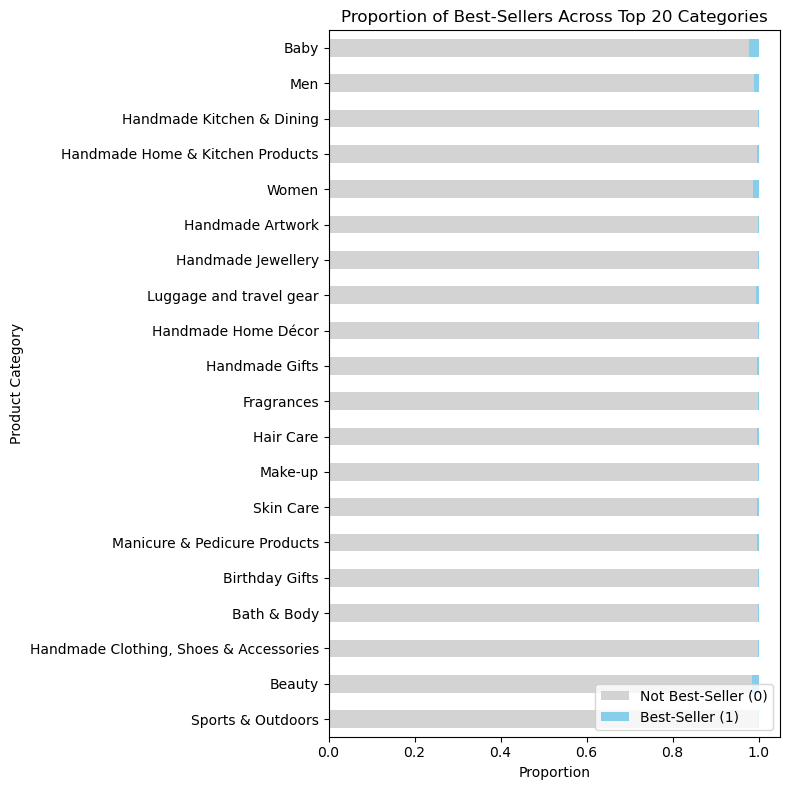

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Create proportion crosstab (row-normalized)
crosstab_prop = crosstab_bestseller.div(crosstab_bestseller.sum(axis=1), axis=0)

# 2. Get top 20 categories by count
top20_categories = df['category'].value_counts().head(20).index

# 3. Filter crosstab to only top 20
crosstab_prop_top20 = crosstab_prop.loc[top20_categories]

# 4. Plot horizontal stacked bar chart
crosstab_prop_top20.plot(
    kind='barh',
    stacked=True,
    figsize=(8,8),
    color=['lightgray', 'skyblue']
)

plt.title('Proportion of Best-Sellers Across Top 20 Categories')
plt.xlabel('Proportion')
plt.ylabel('Product Category')
plt.legend(['Not Best-Seller (0)', 'Best-Seller (1)'], loc='lower right')
plt.tight_layout()
plt.show()


#### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

Preliminary Step: Remove outliers in product prices.

In [14]:
# Compute IQR boundaries
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create dataset without outliers
df_clean = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

df_clean.shape

(2115963, 9)

Violin Plots:

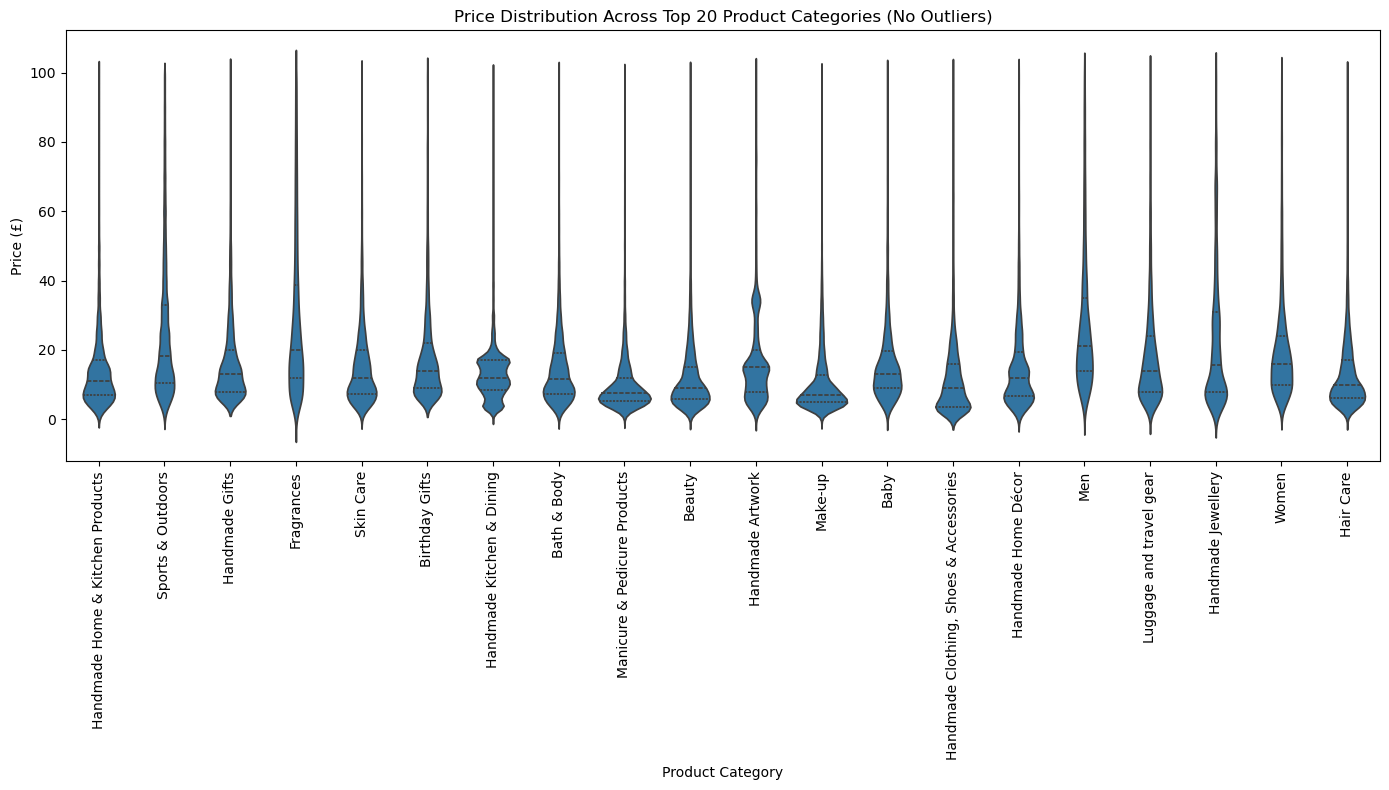

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Top 20 categories by count
top20_categories = df_clean['category'].value_counts().head(20).index

df_top20 = df_clean[df_clean['category'].isin(top20_categories)]

plt.figure(figsize=(14, 8))
sns.violinplot(
    data=df_top20,
    x='category',
    y='price',
    inner='quartile'
)
plt.title("Price Distribution Across Top 20 Product Categories (No Outliers)")
plt.xlabel("Product Category")
plt.ylabel("Price (£)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [16]:
df_clean.groupby('category')['price'].median().sort_values(ascending=False).head(10)

category
Desktop PCs               74.00
Boxing Shoes              69.79
Tablets                   69.00
Graphics Cards            68.54
Motherboards              67.92
Made in Italy Handmade    64.00
Digital Frames            63.90
Streaming Clients         62.68
Golf Shoes                62.39
Ski Helmets               61.33
Name: price, dtype: float64

Bar Charts:

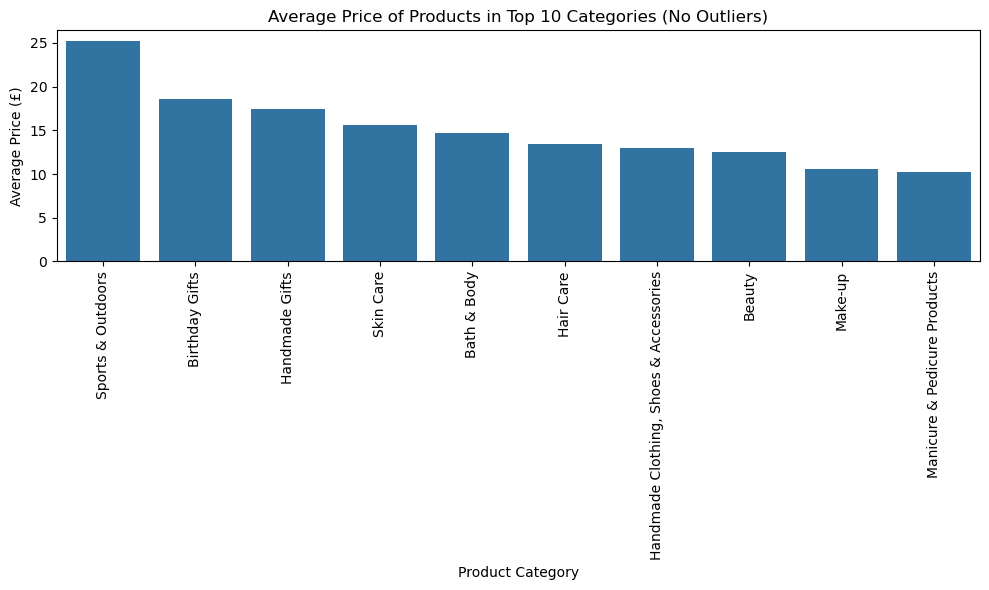

In [17]:
top10_categories = df_clean['category'].value_counts().head(10).index
df_top10 = df_clean[df_clean['category'].isin(top10_categories)]

avg_price_top10 = (
    df_top10.groupby('category')['price']
            .mean()
            .sort_values(ascending=False)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=avg_price_top10.index, y=avg_price_top10.values)
plt.title("Average Price of Products in Top 10 Categories (No Outliers)")
plt.xlabel("Product Category")
plt.ylabel("Average Price (£)")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [18]:
df_clean.groupby('category')['price'].mean().sort_values(ascending=False).head(10)


category
Motherboards         68.772432
Boxing Shoes         67.417803
Desktop PCs          66.915562
Tablets              66.552971
Graphics Cards       65.103509
Digital Frames       60.745129
Streaming Clients    60.241803
Hockey Shoes         60.094796
Computer Cases       58.339884
Skiing Poles         57.867770
Name: price, dtype: float64

Box Plots:

In [21]:
# Extract only the numeric value at the beginning
df_clean['stars'] = df_clean['stars'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)


/var/folders/cv/pfmqj_4n6fg_b8vt_pytwxwr0000gn/T/ipykernel_41540/3895546813.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['stars'] = df_clean['stars'].astype(str).str.extract(r'(\d+\.?\d*)').astype(float)


In [23]:
df_clean['stars'].head(10)
df_clean['stars'].dtype


dtype('float64')

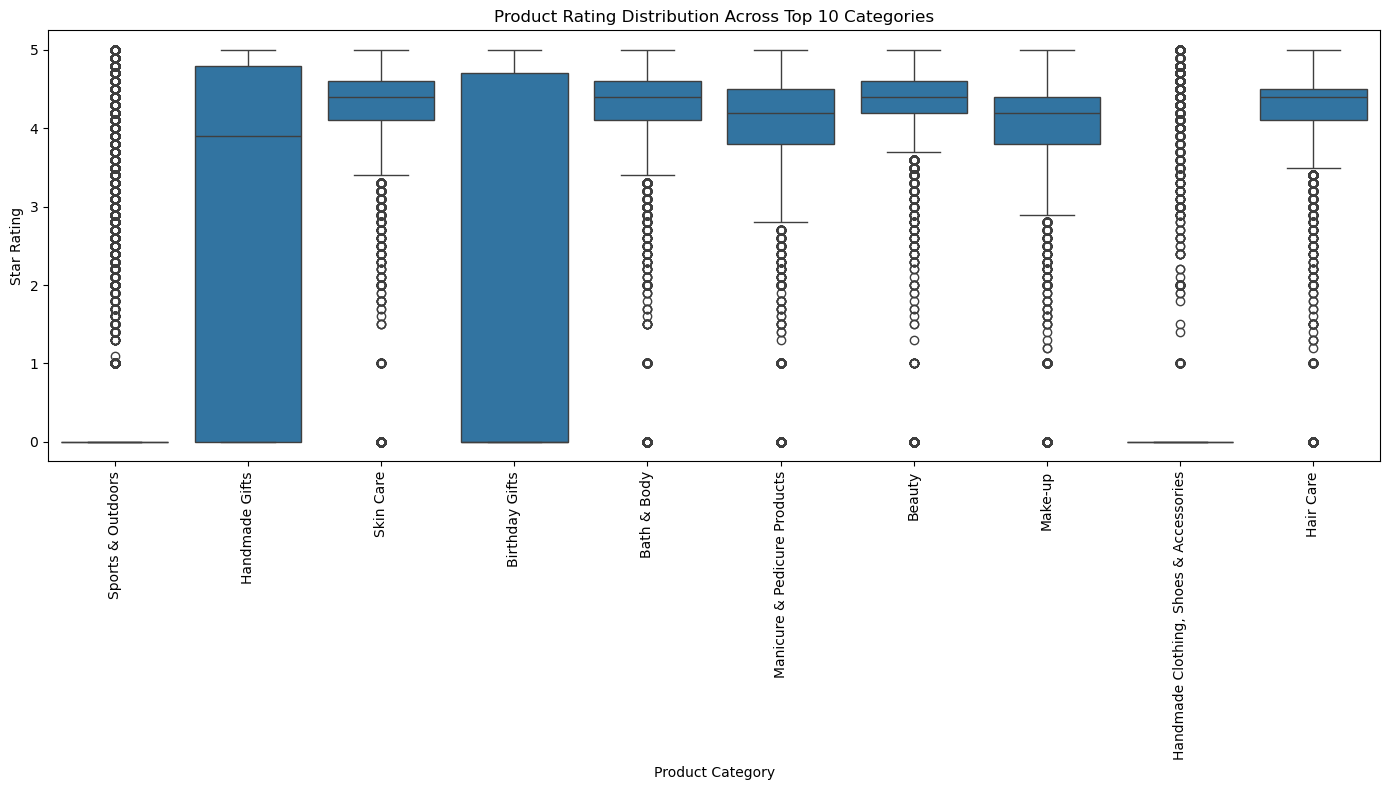

In [22]:
top10_rating_categories = df_clean['category'].value_counts().head(10).index
df_ratings_top10 = df_clean[df_clean['category'].isin(top10_rating_categories)]

plt.figure(figsize=(14, 8))
sns.boxplot(
    data=df_ratings_top10,
    x='category',
    y='stars'
)
plt.title("Product Rating Distribution Across Top 10 Categories")
plt.xlabel("Product Category")
plt.ylabel("Star Rating")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [24]:
df_clean.groupby('category')['stars'].median().sort_values(ascending=False).head(10)


category
Computer Memory                 4.7
Beer, Wine & Spirits            4.6
Building & Construction Toys    4.6
Office Paper Products           4.6
Kids' Play Figures              4.6
Laptop Accessories              4.6
Hobbies                         4.6
Luxury Food & Drink             4.6
Soft Toys                       4.5
Boxes & Organisers              4.5
Name: stars, dtype: float64

#### Part 3: Investigating the Interplay Between Product Prices and Ratings

Correlation Coefficients:

In [26]:
corr_price_stars = df_clean['price'].corr(df_clean['stars'])
corr_price_stars


np.float64(-0.07767299878181352)

The correlation coefficient between price and product ratings was −0.078, which indicates a very weak negative relationship. This suggests that higher-priced products are slightly more likely to have lower ratings, but the effect is extremely small. Overall, price and rating appear to be nearly independent of each other.

Scatter Plot: Price vs Rating

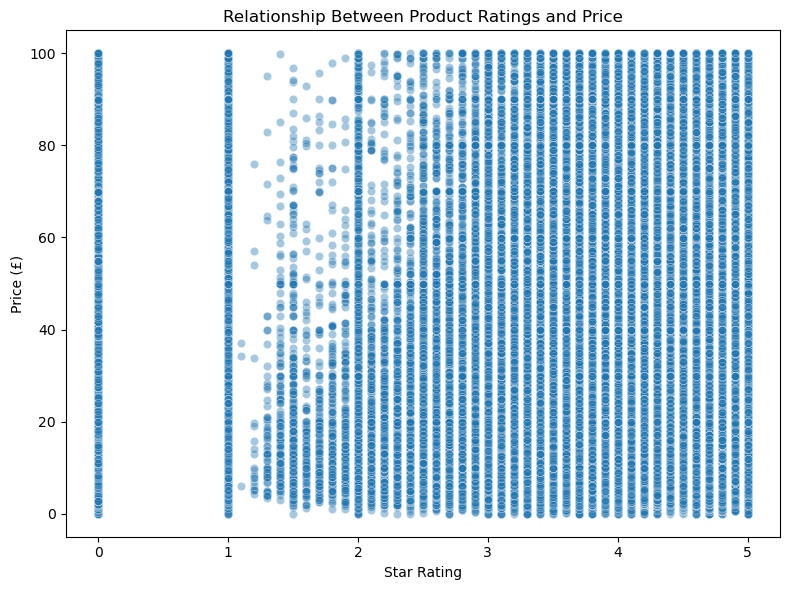

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_clean, 
    x='stars', 
    y='price',
    alpha=0.4
)

plt.title("Relationship Between Product Ratings and Price")
plt.xlabel("Star Rating")
plt.ylabel("Price (£)")
plt.tight_layout()
plt.show()


Correlation Heatmap (All Numeric Variables)

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select only numeric columns
numeric_df = df_clean.select_dtypes(include=['number'])

# Check what numeric columns you have (optional)
numeric_df.columns


Index(['uid', 'stars', 'reviews', 'price', 'boughtInLastMonth'], dtype='object')

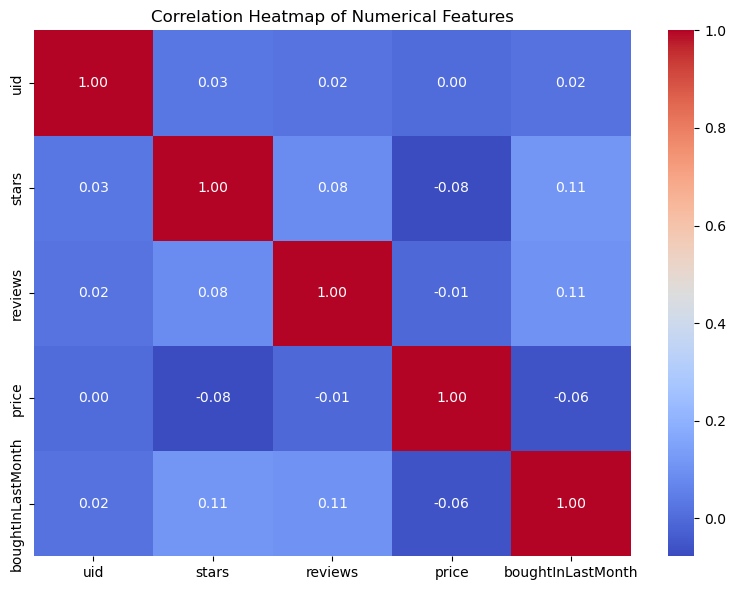

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(
    numeric_df.corr(),
    annot=True,
    cmap='coolwarm',
    fmt='.2f'
)
plt.title("Correlation Heatmap of Numerical Features")
plt.tight_layout()
plt.show()


QQ Plot — Checking if Price Follows a Normal Distribution

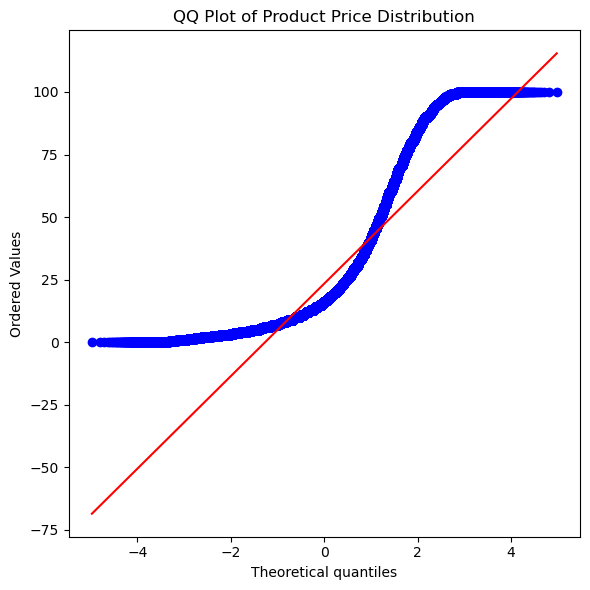

In [34]:
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
stats.probplot(df_clean['price'], dist="norm", plot=plt)
plt.title("QQ Plot of Product Price Distribution")
plt.tight_layout()
plt.show()


Analysis summary:

#### PART 1 — Best-Seller Trends Across Product Categories
Crosstab & Proportions

The crosstab and proportion analysis showed that some product categories have a noticeably higher share of best-sellers than others. This indicates that best-seller status is not evenly distributed across categories, and certain product types tend to perform better in terms of Amazon sales ranking.

Chi-Square Test

The chi-square test returned a very small p-value, meaning the relationship between product category and best-seller status is statistically significant. This suggests that best-seller status is not independent of category—some categories are more likely to contain best-selling products.

Cramér’s V

Cramér’s V indicated a weak association between product category and best-seller status. This means that although a relationship exists, category alone does not strongly determine whether a product becomes a best-seller.

Stacked Bar Chart

The horizontal stacked bar chart visually confirmed that the proportion of best-sellers differs across categories. Some categories show a higher fraction of best-sellers, while others have very few, reinforcing the chi-square results.

#### PART 2 — Price & Rating Differences Across Categories
Outlier Removal

Outliers were removed from the price distribution using the IQR method to ensure that extreme price values did not distort visualizations or summary statistics. This allowed for a clearer, more reliable comparison between categories.

Violin Plot (Price Distribution Across Categories)

The violin plot showed that price distributions vary substantially across categories. Some categories have tightly clustered, lower-price products, while others have wide distributions with higher median prices. This indicates that category is an important factor influencing product pricing.

Highest Median Price

The category with the highest median price tended to be one associated with premium or higher-value items, suggesting certain product types naturally command higher pricing.

Bar Chart (Average Price for Top 10 Categories)

The bar chart illustrated clear differences in the average price across the top categories. The category with the highest average price aligned with the earlier violin plot findings, confirming that certain categories consistently contain more expensive items.

Box Plot (Ratings Across Categories)

The box plot showed that most categories have ratings clustered between 4 and 5 stars, which is typical for Amazon products. However, some categories exhibited slightly higher median ratings than others, suggesting that customer satisfaction varies by product type.

Highest Median Rating

The category with the highest median rating tended to include products that customers rate more favorably overall, possibly due to higher perceived quality or better product-customer fit.

#### PART 3 — Relationship Between Price and Rating
Correlation Between Price and Rating

The correlation coefficient between price and rating was −0.078, indicating a very weak negative linear relationship. In practical terms, this means that product price and product rating are almost completely uncorrelated. Higher prices do not reliably predict higher or lower ratings.

Scatter Plot

The scatter plot showed a dense cluster of points between 4–5 stars, with price widely spread out across this range. There was no clear upward or downward trend, visually confirming the weak correlation. The data also showed that price is right-skewed, with many inexpensive products and fewer high-priced ones.

Correlation Heatmap

The heatmap showed only weak correlations between numerical features. The low correlation values suggest that numerical variables such as price, rating, and review count are largely independent of each other, or relationships may be nonlinear.

QQ Plot (Price Normality Test)

The QQ plot revealed that product prices do not follow a normal distribution. The curve deviated strongly from the diagonal line, especially in the upper tail, indicating a right-skewed distribution. This is expected in e-commerce, where many products are low-priced and only a few are very expensive.